In [93]:
import LibsControl
import numpy
import matplotlib.pyplot as plt

#sampling frequency, 256Hz
dt       = 1.0/256.0

max_velocity = 50


#continuous time dynamics, servo model, with inertia
mat_a = numpy.zeros((2, 2))
mat_b = numpy.zeros((2, 1))
mat_c = numpy.eye(2)

tau = 0.01

mat_a[0][0] = -1.0/tau
mat_a[1][0] = 1.0
mat_b[0][0] = 1.0/tau



#create dynamical system
ds = LibsControl.DynamicalSystem(mat_a, mat_b, mat_c, dt)

print("continuous model")
print(ds)

continuous model
mat_a = 
-100.0 0.0 
1.0 0.0 


mat_b = 
100.0 
0.0 


mat_c = 
1.0 0.0 
0.0 1.0 





<Figure size 640x480 with 0 Axes>

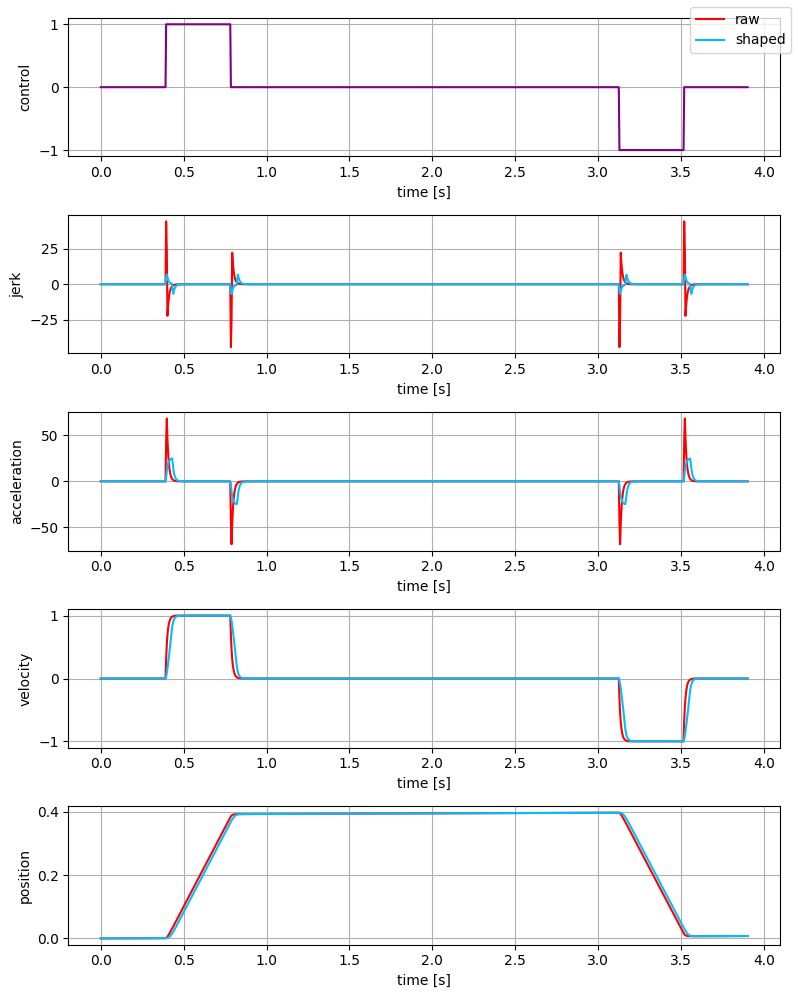

In [94]:

#process simulation
n_max = 1000


def process_response(n_max, shaping):

    #result log
    t_result = []
    u_result = []
    jerk_result = []
    acc_result = []
    x_result = []



    v0 = 0.0
    v1 = 0.0
    v2 = 0.0

    #initial motor state
    ds.reset()

    u_max = 1.0

    u_curr = 0.0

    du_p_max = 20*dt
    du_n_max = -20*dt



    for n in range(n_max):

        #control input
        if n > 0.9*n_max:
            u = 0.0
        elif n > 0.8*n_max:
            u = -u_max
        elif n > 0.2*n_max:
            u = 0.0
        elif n > 0.1*n_max:  
            u = u_max
        else:
            u = 0.0


        if shaping:
            dif = u - u_curr

            if dif > du_p_max:
                u_curr+= du_p_max
            elif dif < du_n_max:
                u_curr+= du_n_max
            else:
                u_curr = u

            u = u_curr*numpy.ones((1, 1))
        else:
            u = u*numpy.ones((1, 1))
            

        #u = u*numpy.ones((1, 1))
        
        
        #compute plant output
        x, y = ds.forward_state(u)

        v2 = v1
        v1 = v0
        v0 = y[0, 0]

        acc  = (v0 - v1)/dt
        jerk = (v0 - 2.0*v1 + v2)/dt

    
        t_result.append(n*dt)
        u_result.append(u[:, 0].copy())
        jerk_result.append(jerk)
        acc_result.append(acc)
        x_result.append(x[:, 0].copy())

        
        
    t_result = numpy.array(t_result)
    u_result = numpy.array(u_result)
    jerk_result = numpy.array(jerk_result)
    acc_result = numpy.array(acc_result)
    x_result = numpy.array(x_result)


    jerk_result = numpy.expand_dims(jerk_result, 1)
    acc_result = numpy.expand_dims(acc_result, 1)


    return t_result, u_result, jerk_result, acc_result, x_result


t_result_raw, u_result_raw, jerk_result_raw, acc_result_raw, x_result_raw = process_response(n_max, False)
t_result_shaped, u_result_shaped, jerk_result_shaped, acc_result_shaped, x_result_shaped = process_response(n_max, True)


plt.clf()

fig, axs = plt.subplots(5, 1, figsize=(8, 2*5))


axs[0].plot(t_result_raw, u_result_raw[:, 0], color="purple")
axs[0].set_xlabel("time [s]")
axs[0].set_ylabel("control")
axs[0].grid()


axs[1].plot(t_result_raw, jerk_result_raw[:, 0], label="raw", color="red")
axs[1].plot(t_result_raw, jerk_result_shaped[:, 0], label="shaped", color="deepskyblue")
axs[1].set_xlabel("time [s]")
axs[1].set_ylabel("jerk")
axs[1].grid()

axs[2].plot(t_result_raw, acc_result_raw[:, 0], color="red")
axs[2].plot(t_result_raw, acc_result_shaped[:, 0], color="deepskyblue")
axs[2].set_xlabel("time [s]")
axs[2].set_ylabel("acceleration")
axs[2].grid()

axs[3].plot(t_result_raw, x_result_raw[:, 0], color="red")
axs[3].plot(t_result_raw, x_result_shaped[:, 0], color="deepskyblue")
axs[3].set_xlabel("time [s]")
axs[3].set_ylabel("velocity")
axs[3].grid()

axs[4].plot(t_result_raw, x_result_raw[:, 1], color="red")
axs[4].plot(t_result_raw, x_result_shaped[:, 1], color="deepskyblue")
axs[4].set_xlabel("time [s]")
axs[4].set_ylabel("position")
axs[4].grid()

fig.legend()

plt.tight_layout()
